# Adam Research Linear Solvers 

In [1]:
using LinearAlgebra
using SparseArrays
using DelimitedFiles
using IterativeSolvers
using Preconditioners
using Plots

## Section 1: Introduction - Research Proposal 

The goal of the project is to replace a commercial [algebraic multigrid (AMG)](https://en.wikipedia.org/wiki/Multigrid_method) code using in an application code by a public domain one. Given previous experience, we will adopt AMG codes available within the [PETSc](https://petsc.org) library.  We envisage three directions of work: 

<b>(1/3) Operate Application Code</b> 
1. learn how to operate application code for case setup, solve and visualization;
2. write linear systems to file; 

<b>(2/3) Linear System Solve using AMG in Julia by calling PETSc</b> Intended as intermediate step and proof of concept. Allows to check that application code writes proper linear system output. 
1. develop code in Julia reads linear system from file and assembles matrix and right-hand side vector as Julia objects(see below); 
1. solves using AMG avalailable within [Preconditioners.jl](https://github.com/JuliaLinearAlgebra/Preconditioners.jl) (see below);
1. solves using  [PETSc2.jl](https://www.optimaldesignlab.com/PETSc2.jl/latest/index.html). 

<b>(3/3) Linear System Solve using PETSc</b> 
1. develop program in Fortran or C that reads linear system from file, assembles matrix and right-hand side vector as PETSc objects and solves the linear system using KSP components within [PETSc](https://petsc.org) and write the solution computed to file;
1. advice how to call PETSc directly from the application code (compile and link phase on Windows system); 

<img src="overview.png" width=700 />

## Section 2: Read Sparse Matrix and RHS Data Files from Disk and Convert to Linear System (Old Format requires skipstart=1) 

In [76]:
filebase = "plate_5mm/"
file = open(filebase*"B.dat", "r")
b = readdlm(file, Float64, skipstart=1); 
length(b)

1200

In [77]:
n = length(b) 
file = open(filebase*"ia.dat", "r")
ia = readdlm(file, Int64, skipstart=1); 
ia = reduce(vcat,ia)
file = open(filebase*"ja.dat", "r")
ja = readdlm(file, Int64, skipstart=1); 
ja = reduce(vcat,ja)
file = open(filebase*"A.dat", "r")
a = readdlm(file, Float64, skipstart=1)
a = reduce(vcat,a);
A = SparseMatrixCSC(n,n,ia,ja,a)

1200×1200 SparseMatrixCSC{Float64, Int64} with 7360 stored entries:
⎡⢿⣷⣄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠙⢦⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎤
⎢⠀⠙⢿⣷⣄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠙⢦⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠙⢿⣷⣄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠙⢦⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠙⢿⣷⣄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠙⢦⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠙⢿⣷⣄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠙⢦⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠙⢿⣷⣄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠙⢦⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⣄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠙⠿⣧⣄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠙⢦⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠈⠳⣄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠙⢿⣷⣄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠙⢦⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠈⠳⣄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠙⢿⣷⣄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠙⢦⡀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠈⠳⣄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠙⢿⣷⣄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠙⢦⡀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠈⠳⣄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠙⢿⣷⣄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠙⢦⡀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠈⠳⣄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠙⢿⣷⣄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠙⢦⡀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠳⣄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠙⢿⣷⣄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠙⢦⡀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠳⣄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠙⢻⣶⣄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠙⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠳⣄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠙⢿⣷⣄⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠳⣄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠙⢿⣷⣄⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠳⣄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠙⢿⣷⣄⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠳⣄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠙⢿⣷⣄⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠳⣄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠙⢿⣷⣄⠀⎥
⎣⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠳⣄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠙⢿⣷⎦

In [78]:
prec  = AMGPreconditioner{RugeStuben}(A)
x, ch = cg(A, b, Pl=prec, maxiter=100000, log=true)

display(ch)

Converged after 5 iterations.

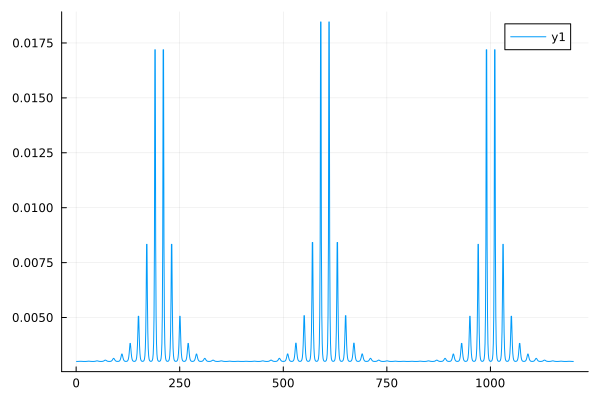

In [79]:
plot(x)

## Section 3: To be filled in

## Section 4: Read Sparse Matrix and RHS Data Files from Disk and Convert to Linear System   

### Section 1.4: Read RHS vector (case MCP1630(kfirstcomp) of size 7103)  
Skip over first line to skip size information.

In [51]:
filebase = "MCP1630(kfirstcomp)/"
file = open(filebase*"B.dat", "r")
b = readdlm(file, Float64, skipstart=0); 
length(b)

7103

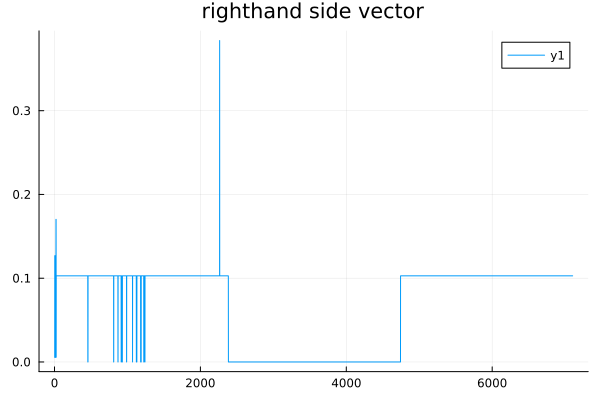

In [52]:
plot(b,title = "righthand side vector")

### Section 2.4: Read sparse coefficient matrix case MCP1630(kfirstcomp) of size 7103-by-7103 and 44355 non-zero elements from file 
1. ia is one element longer than problem size. This is because ia[end] - ia[end-1] holds the number of non-zeros of the last row of the coefficient matrix. Read by skipping over one line of row information;
1. ja is an integer vector of size 44355. ja contains the column index of the non-zero entries; 
1. a is a float vector of size 44355. a contains matrix entries. 

In [54]:
n = length(b) 
file = open(filebase*"ia.dat", "r")
ia = readdlm(file, Int64, skipstart=0); 
ia = reduce(vcat,ia)
file = open(filebase*"ja.dat", "r")
ja = readdlm(file, Int64, skipstart=0); 
ja = reduce(vcat,ja)
file = open(filebase*"A.dat", "r")
a = readdlm(file, Float64, skipstart=0)
a = reduce(vcat,a);

In [55]:
A = SparseMatrixCSC(n,n,ia,ja,a)

7103×7103 SparseMatrixCSC{Float64, Int64} with 44355 stored entries:
⎡⠻⣦⡈⠀⠈⠉⠉⠁⠀⠀⠀⠀⠀⠘⢦⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎤
⎢⠂⠈⠻⣦⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠙⢦⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⡆⠀⠀⠈⠻⣦⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠙⢦⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠇⠀⠀⠀⠀⠈⠻⣦⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠙⢦⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠈⠻⣦⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠙⢦⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠻⣦⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠙⢦⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⣀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠻⢆⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠙⢦⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠈⠳⣄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠻⣦⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠙⢦⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠈⠳⣄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠻⣦⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠙⢦⡀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠈⠳⣄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠻⣦⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠙⢦⡀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠈⠳⣄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠻⣦⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠙⢦⡀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠈⠳⣄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠻⣦⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠙⢦⡀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠳⣄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠻⣦⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠙⢦⡀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠳⣄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠻⣦⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠙⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠳⣄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠻⣦⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠳⣄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠻⣦⡀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠳⣄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠻⣦⡀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠳⣄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠻⣦⡀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠳⣄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠻⣦⡀⠀⎥
⎣⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠳⣄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠻⣦⎦

### Section 3.4: Check whether Matrix is Symmetric 

In [56]:
issymmetric(A)

false

### Section 4.4: Check whether Matrix is Diagonal Dominant 
Assume $v$ to be a vector of all ones. Assume $w = A \, v$. If matrix $A$ is diagonally dominant, then $w > 0$ component wise. 
Computations show that $\text{Transpose}(A)$ is diagonally dominant, while $A$ is not. 

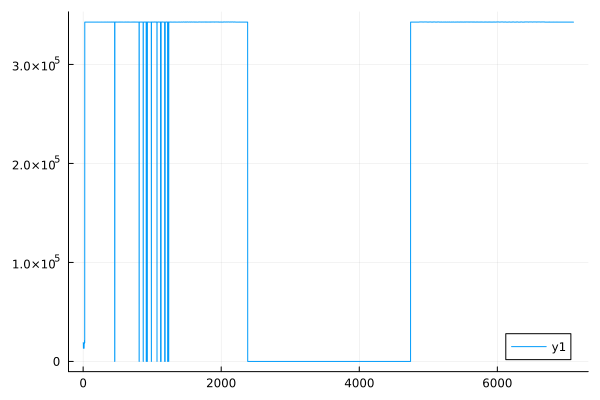

In [57]:
on = ones(n)
ontimesA = Transpose(A)*on
plot(ontimesA)

### Section 5.4: Read Solution vector (for verification purposes) of size 7103 
Again, skip over first line to skip size information.

In [58]:
#file = open("MCP1630(kfirstcomp)/X.dat", "r")
#x = readdlm(file, Float64, skipstart=0); 

## Section 5: Solve by (Sparse) Direct Method Providing a Reference Solution 

### Section 1.5: Transposing Matrix Prior to Solve 

In [68]:
F = lu(Transpose(A));
x_direct = F\b; 

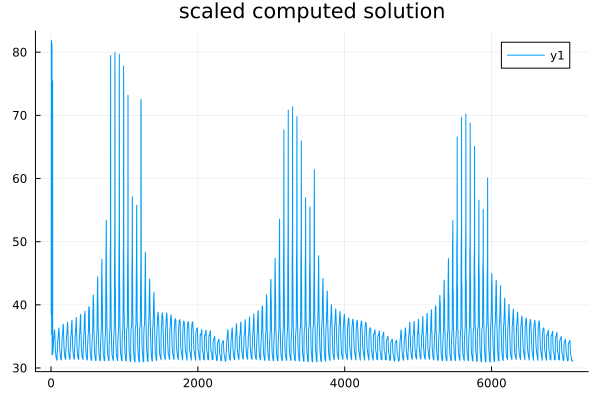

In [69]:
plot(1e8*x_direct,title="scaled computed solution")

## Section 6: Solve by iterative method 

In [61]:
prec  = AMGPreconditioner{RugeStuben}(Transpose(A))
u, ch = cg(A, b, Pl=prec, maxiter=100000, log=true)

display(ch)

LoadError: MethodError: no method matching ruge_stuben(::Transpose{Float64, SparseMatrixCSC{Float64, Int64}})

[0mClosest candidates are:
[0m  ruge_stuben([91m::Union{Hermitian{Ti, TA}, Symmetric{Ti, TA}, TA}[39m) where {Ti, Tv, TA<:SparseMatrixCSC{Ti, Tv}}
[0m[90m   @[39m [35mAlgebraicMultigrid[39m [90m~/.julia/packages/AlgebraicMultigrid/ASpK7/src/[39m[90m[4mclassical.jl:10[24m[39m
[0m  ruge_stuben([91m::Union{Hermitian{Ti, TA}, Symmetric{Ti, TA}, TA}[39m, [91m::Type{Val{bs}}[39m; strength, CF, presmoother, postsmoother, max_levels, max_coarse, coarse_solver, kwargs...) where {Ti, Tv, bs, TA<:SparseMatrixCSC{Ti, Tv}}
[0m[90m   @[39m [35mAlgebraicMultigrid[39m [90m~/.julia/packages/AlgebraicMultigrid/ASpK7/src/[39m[90m[4mclassical.jl:10[24m[39m


In [13]:
u

LoadError: UndefVarError: `u` not defined

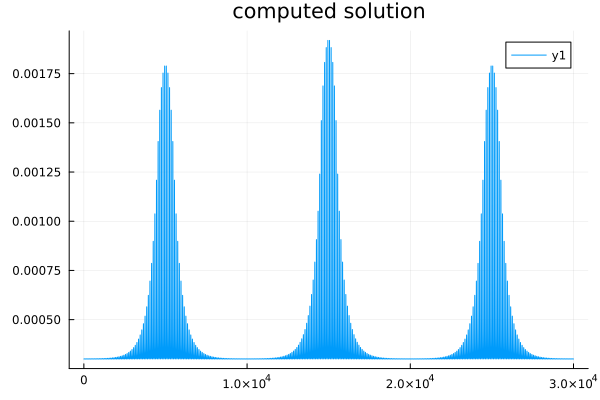

In [11]:
plot(u, title="computed solution")

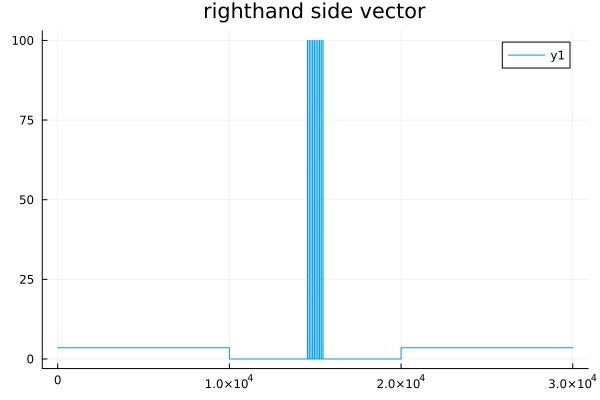

In [13]:
plot(b, title = "righthand side vector")